In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import pingouin as pg

from sklearn.linear_model import LinearRegression

from statsmodels.stats import multitest, multicomp
import statsmodels.formula.api as smf

from statsmodels.sandbox.stats.multicomp import multipletests
import math
from scipy.special import logit

sns.set(font_scale=1.3)



Data is presented in [github](https://github.com/OrsolyaVincze/VinczeEtal2021Nature)

In [2]:
df = pd.read_csv('data.csv')

data.csv - Database containing species-specific cancer mortality risk, sample sizes, diet, body mass, sexual maturity and adult life expectancy. Included variables are as follows:

Species     	- Binomial scientific name of the taxa

order       	- Taxonomic order of the species

FemaleMeanMass 	- Average body mass of adult females (kg)

MaleMeanMass   	- Average body mass of adult males (kg)

CMR	       	- Adult cancer mortality risk. The variable takes values between 0 and 1.

ICM	       	- Incidence of cancer mortality in adults. The variable takes values between 0 and 1.

lifeexp	       	- Average number of days lived after sexual maturity was reached, i.e. remaining life expectancy.

Sample	       	- Total number of individuals per species in the database.

Deaths	       	- Total number of dead individuals per species in the database.

Neoplasia	- Total number of neoplasia cases recorded in each species, that were considered to be significant contributors to the death of the animals. Please note that (although possible) benign tumors are unlikely to be reported here.

knownDeaths	- Total number of dead individuals whose pathological records (i.e. most likely causes of death) were identified and entered in the husbandry database.

Animal	        - Animal presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).

Vertebrate	- Vertebrate prey presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).

Invertebrate	- Invertebrate prey presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).

Fish	        - Fish prey presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).

Herptile	- Reptile prey presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).

Bird	        - Bird prey presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).

Mammal          - Mammalian prey presence (1) or absence (0) in the diet. Following: Kissling et al. Ecol. Evol. 4, 2913–2930 (2014).


In [4]:
df.head()

,Unnamed: 0,Species,order,FemaleMeanMass,MaleMeanMass,CMR,ICM,lifeexp,Sample,Deaths,Neoplasia,knownDeaths,Animal,Vertebrate,Invertebrate,Fish,Herptile,Bird,Mammal
0,1,Acinonyx_jubatus,Carnivora,39.906168,45.193976,0.035556,0.041555,3533.859621,1560,649,8,225,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2,Addax_nasomaculatus,Artiodactyla,102.281106,118.985007,0.035714,0.061624,3127.886214,762,336,3,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Aepyceros_melampus,Artiodactyla,42.373844,53.925686,0.057325,0.141182,2465.892908,1007,537,9,157,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Ailurus_fulgens,Carnivora,5.921639,6.029143,0.070707,0.073361,3580.261306,1068,421,7,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Alces_alces,Artiodactyla,292.792354,397.025427,0.000000,0.000000,2103.783182,246,147,0,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)  
df.columns

Index(['Species', 'order', 'FemaleMeanMass', 'MaleMeanMass', 'CMR', 'ICM',
       'lifeexp', 'Sample', 'Deaths', 'Neoplasia', 'knownDeaths', 'Animal',
       'Vertebrate', 'Invertebrate', 'Fish', 'Herptile', 'Bird', 'Mammal'],
      dtype='object')

In [4]:
df['bodyMass'] = (df['FemaleMeanMass'] + df['MaleMeanMass'])/2
df.lifeexp /= 365

### The dependence of cancer risk on belonging to an order

Let's look whether CMR and ICM correlate each other

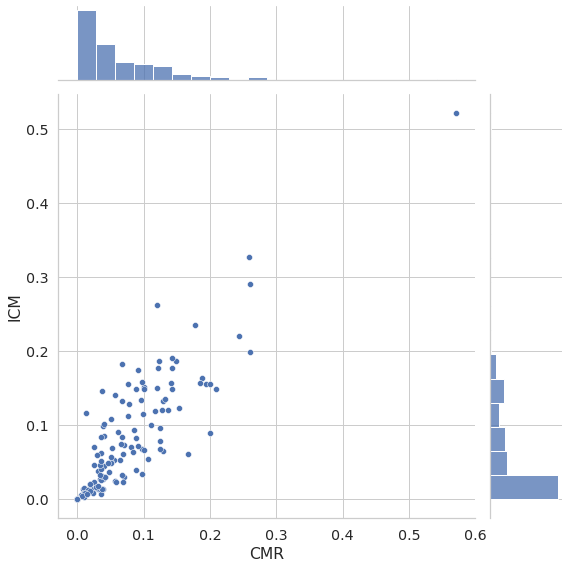

In [37]:

sns.set_style('whitegrid')
sns.jointplot(x='CMR', y='ICM', data=df, kind="scatter",dropna=True,height=8)

plt.show()

In [15]:
df.shape

(191, 19)

In [16]:
sps.shapiro(df['CMR'].dropna())

ShapiroResult(statistic=0.7603750824928284, pvalue=2.3710585657883763e-16)

In [17]:
sps.shapiro(df['ICM'].dropna())

ShapiroResult(statistic=0.785233736038208, pvalue=1.2957051982720718e-14)

Samples are big enough with rejected hypotesis about normal distribution. So it's better to use Spearman correlation

In [103]:

sps.spearmanr(df[['CMR','ICM']].dropna()['CMR'], df[['CMR','ICM']].dropna()['ICM'])

SpearmanrResult(correlation=0.9286703935125468, pvalue=3.9145337445636546e-75)

Positive correlation is observed. So it's possible to use only one of this parametrs. Let it be CMR

In [38]:
df.value_counts(subset=['order'])

order         
Artiodactyla      65
Primates          42
Carnivora         41
Rodentia          16
Chiroptera         9
Diprotodontia      6
Perissodactyla     6
Afrosoricida       1
Dasyuromorphia     1
Hyracoidea         1
Macroscelidea      1
Pilosa             1
Scandentia         1
dtype: int64

In [5]:
big_order=['Artiodactyla','Primates','Carnivora','Rodentia','Chiroptera','Diprotodontia','Perissodactyla']

In [6]:
big_order_df= df[df['order'].isin(big_order)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'upperright'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


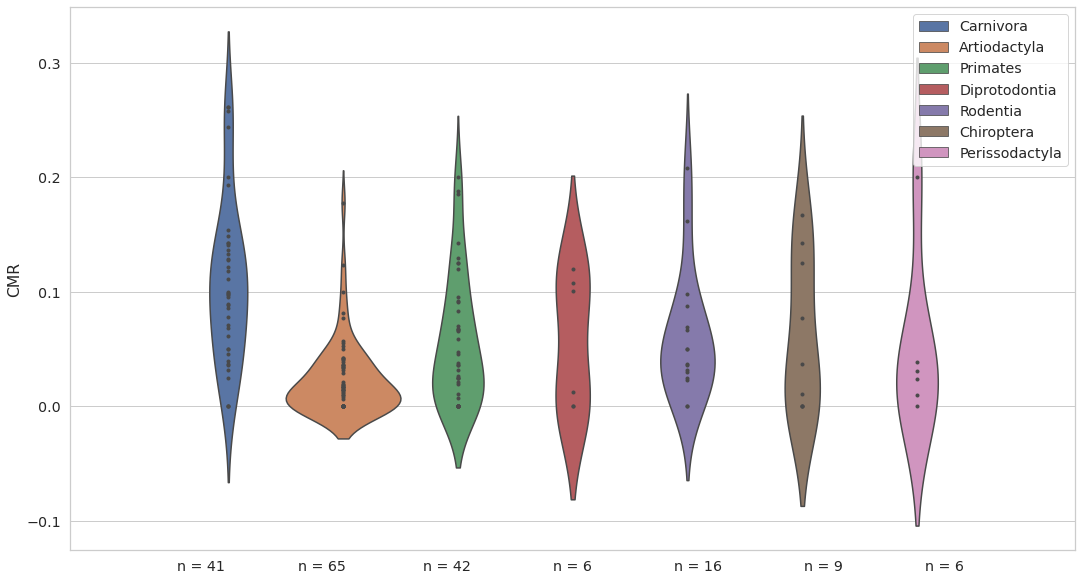

In [95]:
plt.figure(figsize=(18,10))
sns.violinplot(x=[""]*len(big_order_df['CMR']), y=big_order_df['CMR'],hue=big_order_df['order'],inner='point')
plt.legend(loc='upperright')

#yposlist = big_order_df.groupby(['order'])['CMR'].median().tolist()
#xposlist = range(len(yposlist))
stringlist = ['n = 41','n = 65','n = 42','n = 6','n = 16','n = 9','n = 6']
plt.xticks([-0.37,-0.25,-0.125,0,0.125,0.25,0.37], stringlist)
#for i in range(len(stringlist)):
 #   ax.text(xposlist[i], yposlist[i], stringlist[i])
plt.show()

We can see that the median of the carnivores is skewed toward higher CMR values, and so is the interquartile range and outliers
___

In [102]:
for order in big_order:
  print(sps.shapiro(big_order_df[big_order_df['order']==order]['CMR']))
  


ShapiroResult(statistic=0.7162197828292847, pvalue=6.639482852399681e-10)
ShapiroResult(statistic=0.8725461959838867, pvalue=0.00023938486992847174)
ShapiroResult(statistic=0.9386107921600342, pvalue=0.028167393058538437)
ShapiroResult(statistic=0.8413094878196716, pvalue=0.010175768285989761)
ShapiroResult(statistic=0.8439830541610718, pvalue=0.06394550204277039)
ShapiroResult(statistic=0.7824721932411194, pvalue=0.040641915053129196)
ShapiroResult(statistic=0.6767776012420654, pvalue=0.0034862442407757044)


In [104]:
samples=[]
for order in big_order:
  samples.append(list(big_order_df[big_order_df['order']==order]['CMR']))

In [106]:
sps.levene(*samples),sps.kruskal(*samples)

(LeveneResult(statistic=3.9241297114867257, pvalue=0.0010428322503278882),
 KruskalResult(statistic=47.12051808912017, pvalue=1.770372993221779e-08))

Levene test showed significant defferences in case of variance and Kruskal -  in according to  medians

____

### Post hoc analysis

In [9]:
big_order

['Artiodactyla',
 'Primates',
 'Carnivora',
 'Rodentia',
 'Chiroptera',
 'Diprotodontia',
 'Perissodactyla']

In [13]:
t_data=[]

for column1 in big_order:
  for column2 in big_order:
    if column1 != column2:
      p = (sps.ttest_ind(big_order_df[big_order_df['order']==column1]['CMR'], big_order_df[big_order_df['order']==column2]['CMR'], equal_var=False)[1])
      diff=(np.mean(big_order_df[big_order_df['order']==column1]['CMR'])-np.mean(big_order_df[big_order_df['order']==column2]['CMR']))
      t_data.append([column1,column2,p,diff])

In [27]:
t_df = pd.DataFrame.from_records(t_data)
t_df.columns = ['Order1', 'Order2', 'p_unc', 'm2-m2']

In [28]:
t_df.insert(4,'p_cor',multipletests(t_df['p_unc'], alpha=0.1, method='holm')[1])
t_df.insert(4,'reject',multipletests(t_df['p_unc'], alpha=0.1, method='holm')[0])

In [29]:
t_df[t_df['reject']==True]

,Order1,Order2,p_unc,m2-m2,reject,p_cor
0,Artiodactyla,Primates,1.026912e-03,-0.033182,True,3.902266e-02
1,Artiodactyla,Carnivora,2.849309e-09,-0.083301,True,1.196710e-07
6,Primates,Artiodactyla,1.026912e-03,0.033182,True,3.902266e-02
7,Primates,Carnivora,5.739047e-04,-0.050119,True,2.295619e-02
12,Carnivora,Artiodactyla,2.849309e-09,0.083301,True,1.196710e-07
13,Carnivora,Primates,5.739047e-04,0.050119,True,2.295619e-02


### Tukey and Games-Howell tests

In [12]:
tukey=multicomp.pairwise_tukeyhsd(endog=big_order_df['CMR'],groups=big_order_df['order'],alpha=0.05)

In [14]:
print(tukey)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
  Artiodactyla      Carnivora   0.0833    0.0  0.0511  0.1155   True
  Artiodactyla     Chiroptera    0.039 0.4034 -0.0185  0.0964  False
  Artiodactyla  Diprotodontia   0.0335 0.7732 -0.0354  0.1024  False
  Artiodactyla Perissodactyla   0.0272 0.9009 -0.0416  0.0961  False
  Artiodactyla       Primates   0.0332 0.0362  0.0012  0.0651   True
  Artiodactyla       Rodentia   0.0376 0.1685 -0.0074  0.0827  False
     Carnivora     Chiroptera  -0.0443 0.2871 -0.1038  0.0151  False
     Carnivora  Diprotodontia  -0.0498 0.3543 -0.1203  0.0208  False
     Carnivora Perissodactyla  -0.0561 0.2179 -0.1266  0.0145  False
     Carnivora       Primates  -0.0501 0.0008 -0.0856 -0.0147   True
     Carnivora       Rodentia  -0.0457 0.0691 -0.0932  0.0019  False
    Chiroptera  Diprotodontia  -0.

In [10]:
howell=pg.pairwise_gameshowell(data=big_order_df,dv='CMR',between='order')
howell[howell['pval']<0.05]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Artiodactyla,Carnivora,0.023132,0.106432,-0.083301,0.011609,-7.175503,51.087247,5.868933e-08,-1.420711
4,Artiodactyla,Primates,0.023132,0.056313,-0.033182,0.009602,-3.455677,58.645647,1.680549e-02,-0.679240
9,Carnivora,Primates,0.106432,0.056313,0.050119,0.013948,3.593225,76.890814,9.888218e-03,0.781546


Both test showed significant defferences between Artiodactyla/Carnivora and Artiodactyla/Primates orders 

### Sex-cancer correlation

In [16]:
sex_data = pd.read_csv('sex bias.csv')

In [17]:
sex_data.head()

,Species,knownDeathsF,knownDeathsM,ICM_F,ICM_M,CMR_M,CMR_F,order
0,Acinonyx_jubatus,105,120,0.030140,0.048123,0.033333,0.038095,Carnivora
1,Ailurus_fulgens,47,51,0.115641,0.044528,0.058824,0.085106,Carnivora
2,Aonyx_cinerea,85,74,0.146708,0.015496,0.040541,0.082353,Carnivora
3,Arctictis_binturong,14,13,0.064764,0.188874,0.153846,0.142857,Carnivora
4,Canis_rufus,17,14,0.188612,0.413090,0.428571,0.117647,Carnivora


In [19]:
sex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Species       36 non-null     object 
 1   knownDeathsF  36 non-null     int64  
 2   knownDeathsM  36 non-null     int64  
 3   ICM_F         32 non-null     float64
 4   ICM_M         30 non-null     float64
 5   CMR_M         36 non-null     float64
 6   CMR_F         36 non-null     float64
 7   order         36 non-null     object 
dtypes: float64(4), int64(2), object(2)
memory usage: 2.4+ KB


In [20]:
sps.shapiro(sex_data['CMR_M']),sps.shapiro(sex_data['CMR_F'])

(ShapiroResult(statistic=0.8310582637786865, pvalue=7.182308763731271e-05),
 ShapiroResult(statistic=0.941742479801178, pvalue=0.05756807699799538))

Hypothesis is rejected so it's better to use non parametric criteria

In [22]:
sps.levene(sex_data['CMR_M'],sex_data['CMR_F'])

LeveneResult(statistic=0.6767580548522067, pvalue=0.4134989484621473)

In [23]:
sps.ttest_ind(sex_data['CMR_M'],sex_data['CMR_F'], equal_var=True)

Ttest_indResult(statistic=0.3131762718650713, pvalue=0.7550779736094833)

In [27]:
sps.mannwhitneyu(sex_data['CMR_M'],sex_data['CMR_F'], alternative='less')

MannwhitneyuResult(statistic=606.5, pvalue=0.3219275705313285)

Hypothesis isn't rejected. So the influence of  the use of hormonal contraception on cancer risk isn't proved

___